# Tiny-YOLO PYNQ Inference — HLS Conv Engine

This notebook drives the **`conv_engine`** HLS dataflow IP on a ZCU102 PYNQ board  
to run the complete Tiny-YOLO v2 network (**all 10 layers on HW**, including detection).

## Architecture Overview

| Stage | HLS Module | Function |
|-------|-----------|----------|
| Fetch | `Fetch_Layer` | Tile-based DMA of input + weights from DDR (burst-friendly, BRAM weight cache) |
| Execute | `Execute_Layer` | Tiled MAC, fused BN (scale+bias), activation (LeakyReLU / ReLU / **linear**) |
| Write | `Write_Layer` | Optional 2×2 MaxPool (**stride 1 or 2**), correct 256-bit wide-bus packing |

**Data format:** `ap_fixed<16,8>` — 16-bit fixed point, 8 integer bits (incl. sign), 8 fractional bits.  
**Memory bus:** 256-bit AXI (`ap_uint<256>` = 16× 16-bit values per beat).  
**Tile sizes:** 16×16 spatial, 16 IC, 16 OC.  

### Activation modes (`use_leaky` register)
| Value | Mode |
|-------|------|
| `1` | LeakyReLU (slope ≈ 0.1) |
| `0` | ReLU |
| `-1` | **Linear** (pass-through — for detection layer) |

### Layer Execution Plan

| # | Layer | IC→OC | K | Pool | Notes |
|---|-------|-------|---|------|-------|
| 0 | conv1 | 3→16 | 3 | 2×2 s2 | HW pool |
| 1 | conv2 | 16→32 | 3 | 2×2 s2 | HW pool |
| 2 | conv3 | 32→64 | 3 | 2×2 s2 | HW pool |
| 3 | conv4 | 64→128 | 3 | 2×2 s2 | HW pool |
| 4 | conv5 | 128→256 | 3 | 2×2 s2 | HW pool |
| 5 | conv6 | 256→512 | 3 | 2×2 s1 | HW pool stride-1 (pad+pool fused) |
| 6 | conv7 | 512→1024 | 3 | — | HW conv only |
| 7 | conv8 | 1024→256 | 1 | — | HW conv only |
| 8 | conv9 | 256→512 | 3 | — | HW conv only |
| 9 | det | 512→125 | 1 | — | HW, linear activation (`use_leaky=-1`), BN=identity |

In [48]:
import numpy as np
import struct, time, os
from pynq import Overlay, allocate

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import cv2

## 1. Constants

In [49]:
# ── HLS tile parameters (must match conv_engine.h) ─────────────────────────
TILE_H  = 16
TILE_W  = 16
TILE_IC = 16
TILE_OC = 16
K_MAX   = 3

# ── Fixed-point: ap_fixed<16, 8, AP_RND, AP_SAT> ──────────────────────────
FRAC_BITS    = 8
SCALE_FACTOR = 1 << FRAC_BITS          # 256
FP_MIN       = np.int16(-32768)
FP_MAX       = np.int16(32767)

# ── AXI-Lite register offsets (from xconv_engine_hw.h) ─────────────────────
REG_AP_CTRL      = 0x00
REG_INPUT_DRAM   = 0x10   # 64-bit
REG_OUTPUT_DRAM  = 0x1C   # 64-bit
REG_WEIGHTS_DRAM = 0x28   # 64-bit
REG_BN_PARAMS    = 0x34   # 64-bit
REG_IN_CHANNELS  = 0x40
REG_OUT_CHANNELS = 0x48
REG_IN_HEIGHT    = 0x50
REG_IN_WIDTH     = 0x58
REG_KERNEL_SIZE  = 0x60
REG_STRIDE       = 0x68
REG_PADDING      = 0x70
REG_USE_POOL     = 0x78
REG_POOL_STRIDE  = 0x80
REG_USE_LEAKY    = 0x88

# ── ImageNet normalization (must match training preprocessing) ─────────────
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# ── YOLO parameters ───────────────────────────────────────────────────────
NUM_CLASSES = 80
NUM_ANCHORS = 5
INPUT_SIZE  = 416
GRID_SIZE   = 13

COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle',
    'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush',
]

# Anchors (must match training config — from run_yolo_opencv.py)
ANCHORS = np.array([
    [1.08, 1.19],
    [3.42, 4.41],
    [6.63, 11.38],
    [9.42, 5.11],
    [16.62, 10.52]
], dtype=np.float32)

## 2. Load FPGA Overlay

Place `conv_engine.bit` and `conv_engine.hwh` in the same directory.  
These are generated by Vivado after integrating the HLS IP into a block design  
with a Zynq UltraScale+ PS and AXI interconnects.

In [50]:
BITSTREAM = '/home/xilinx/feb16.bit'     # ← adjust path as needed

ol = Overlay(BITSTREAM)
conv_ip = ol.conv_engine_0        # IP instance name from block design

print(f'Overlay loaded: {BITSTREAM}')
print(f'IP base address: 0x{conv_ip.mmio.base_addr:08X}')
print(f'Register map:\n{conv_ip.register_map}')

Overlay loaded: /home/xilinx/feb16.bit
IP base address: 0xA0000000
Register map:
RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  input_dram_1 = Register(input_dram=write-only),
  input_dram_2 = Register(input_dram=write-only),
  output_dram_1 = Register(output_dram=write-only),
  output_dram_2 = Register(output_dram=write-only),
  weights_dram_1 = Register(weights_dram=write-only),
  weights_dram_2 = Register(weights_dram=write-only),
  bn_params_dram_1 = Register(bn_params_dram=write-only),
  bn_params_dram_2 = Register(bn_params_dram=write-only),
  in_channels = Register(in_channels=write-only),
  out_channels = Register(out_channels=write-only),
  in_height = Register(in_height=write-only),
  in_width = Regis

## 3. Fixed-Point & Batch-Norm Helpers

In [51]:
def float_to_fixed(x, frac_bits=FRAC_BITS):
    """float array  →  ap_fixed<16,8> stored as int16."""
    scaled = np.round(x * (1 << frac_bits)).astype(np.int32)
    return np.clip(scaled, -32768, 32767).astype(np.int16)


def fixed_to_float(x, frac_bits=FRAC_BITS):
    """int16 (ap_fixed<16,8>)  →  float."""
    return x.astype(np.float32) / (1 << frac_bits)


def fuse_conv_bn(conv_weight, conv_bias, bn_gamma, bn_beta,
                 bn_mean, bn_var, eps=1e-5):
    """
    Compute the scale[] and bias[] arrays expected by the HLS BN stage.

    HLS engine does:  val = acc * scale[oc] + bias[oc]
    PyTorch BN does:  y = gamma*(x-mean)/sqrt(var+eps) + beta

    Returns
    -------
    scale : ndarray [OC]   gamma / sqrt(var + eps)
    bias  : ndarray [OC]   beta - gamma*mean / sqrt(var + eps)  (+ conv_bias folded in)
    """
    inv_std = 1.0 / np.sqrt(bn_var + eps)
    scale = bn_gamma * inv_std
    if conv_bias is not None:
        bias = bn_beta + scale * (conv_bias - bn_mean)
    else:
        bias = bn_beta - scale * bn_mean
    return scale.astype(np.float32), bias.astype(np.float32)


def pack_bn_params(scale, bias):
    """
    Interleave scale/bias into the flat layout the HLS IP expects:
      [scale_0, bias_0, scale_1, bias_1, ...]
    Returns int16 array.
    """
    oc = len(scale)
    buf = np.empty(oc * 2, dtype=np.float32)
    buf[0::2] = scale
    buf[1::2] = bias
    return float_to_fixed(buf)


def pad16(n):
    """Round up to next multiple of 16 (256-bit / 16-bit = 16 elements)."""
    return ((n + 15) // 16) * 16

## 4. PyTorch Model Definition & Weight Extraction

We re-define the model here so we can load a `.pth` checkpoint,  
then extract and convert every layer's weights + fused BN parameters.

In [52]:
# ── Re-define the PyTorch model (must match training code) ──────────────────

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride, padding, bias=False)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.act  = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class TinyYOLO(nn.Module):
    def __init__(self, num_classes=80, num_anchors=5, dropout_rate=0.3):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.conv1 = ConvBlock(3, 16, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = ConvBlock(16, 32, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = ConvBlock(32, 64, 3, 1, 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = ConvBlock(64, 128, 3, 1, 1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv5 = ConvBlock(128, 256, 3, 1, 1)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout2d(p=dropout_rate)

        self.conv6 = ConvBlock(256, 512, 3, 1, 1)
        self.pad6  = nn.ZeroPad2d((0, 1, 0, 1))
        self.pool6 = nn.MaxPool2d(2, 1)

        self.dropout2 = nn.Dropout2d(p=dropout_rate)

        self.conv7 = ConvBlock(512, 1024, 3, 1, 1)
        self.dropout3 = nn.Dropout2d(p=dropout_rate)

        self.conv8 = ConvBlock(1024, 256, 1, 1, 0)
        self.conv9 = ConvBlock(256, 512, 3, 1, 1)

        self.detection = nn.Conv2d(512, num_anchors * (5 + num_classes),
                                   1, 1, 0)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))
        x = self.pool5(self.conv5(x))
        x = self.dropout1(x)
        x = self.pool6(self.pad6(self.conv6(x)))
        x = self.dropout2(x)
        x = self.dropout3(self.conv7(x))
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.detection(x)
        return x

In [53]:
# ── Load trained weights ───────────────────────────────────────────────────
WEIGHTS_PATH = '/root/Downloads/tiny_yolo_best.pth'          # ← adjust path

model = TinyYOLO(num_classes=NUM_CLASSES, num_anchors=NUM_ANCHORS)
checkpoint = torch.load(WEIGHTS_PATH, map_location='cpu')

# Handle checkpoint dict format (the .pth is a training checkpoint, not a plain state_dict)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    state = checkpoint['model_state_dict']
    print(f"Checkpoint keys: {list(checkpoint.keys())}")
    if 'val_loss' in checkpoint:
        print(f"  val_loss = {checkpoint['val_loss']:.4f}")
    if 'val_iou' in checkpoint:
        print(f"  val_iou  = {checkpoint['val_iou']:.4f}")
else:
    state = checkpoint          # plain state_dict

# Strip '_orig_mod.' prefix if present (from torch.compile)
clean_state = {}
for k, v in state.items():
    new_k = k[10:] if k.startswith('_orig_mod.') else k
    clean_state[new_k] = v

model.load_state_dict(clean_state, strict=True)   # strict=True to catch mismatches!
model.eval()
print(f'Loaded weights from {WEIGHTS_PATH}  ({len(clean_state)} params)')

Checkpoint keys: ['epoch', 'model_state_dict', 'val_loss', 'val_iou']
  val_loss = 36.5193
  val_iou  = 0.5215
Loaded weights from /root/Downloads/tiny_yolo_best.pth  (56 params)


In [54]:
# ── Extract & convert every layer ──────────────────────────────────────────

def extract_conv_block(block):
    """
    From a ConvBlock, return:
      weights_fp : int16 flat array (OIHW order, matches HLS)
      bn_fp      : int16 flat array [s0,b0,s1,b1,...]
    """
    w = block.conv.weight.detach().numpy()           # [OC, IC, K, K]
    b = block.conv.bias.detach().numpy() if block.conv.bias is not None else None

    gamma = block.bn.weight.detach().numpy()         # [OC]
    beta  = block.bn.bias.detach().numpy()           # [OC]
    mean  = block.bn.running_mean.detach().numpy()   # [OC]
    var   = block.bn.running_var.detach().numpy()    # [OC]

    scale, bias = fuse_conv_bn(w, b, gamma, beta, mean, var)
    weights_fp  = float_to_fixed(w.ravel())          # flat OIHW
    bn_fp       = pack_bn_params(scale, bias)
    return weights_fp, bn_fp


def extract_detection_layer(layer):
    """
    Detection layer: plain Conv2d, no BN → use identity BN params.
    Returns (weights_fp, bn_fp) in the same format as conv blocks,
    so the detection layer can also run on HW with use_leaky=-1.
    
    HLS applies: out = acc * scale + bias
    For identity BN with conv bias folded in: scale=1.0, bias=conv_bias.
    """
    w = layer.weight.detach().numpy()   # [OC, IC, 1, 1]
    b = layer.bias.detach().numpy()     # [OC]
    
    weights_fp = float_to_fixed(w.ravel())
    
    # Identity BN: scale=1.0 for all channels, bias=conv_bias
    oc = w.shape[0]
    scale = np.ones(oc, dtype=np.float32)
    bn_fp = pack_bn_params(scale, b)
    return weights_fp, bn_fp


# ── ap_fixed<16,8> range check ──────────────────────────────────────────────
FP16_8_MIN = -128.0
FP16_8_MAX = 32767.0 / 256.0   # ≈ 127.996

def check_overflow(name, values):
    """Warn if any values exceed ap_fixed<16,8> range."""
    over = np.sum((values < FP16_8_MIN) | (values > FP16_8_MAX))
    if over > 0:
        print(f'  ⚠ {name}: {over}/{len(values)} values overflow '
              f'ap_fixed<16,8> [{FP16_8_MIN}, {FP16_8_MAX:.3f}]  '
              f'range=[{values.min():.3f}, {values.max():.3f}]')


# Extract all ConvBlock layers
conv_blocks = [model.conv1, model.conv2, model.conv3, model.conv4,
               model.conv5, model.conv6, model.conv7, model.conv8, model.conv9]

hw_weights = []   # list of int16 flat arrays
hw_bn      = []   # list of int16 flat arrays
for i, blk in enumerate(conv_blocks):
    w, bn = extract_conv_block(blk)
    hw_weights.append(w)
    hw_bn.append(bn)
    # Check BN scale/bias overflow
    wf = blk.conv.weight.detach().numpy()
    bf = blk.conv.bias.detach().numpy() if blk.conv.bias is not None else None
    gamma = blk.bn.weight.detach().numpy()
    beta  = blk.bn.bias.detach().numpy()
    mean  = blk.bn.running_mean.detach().numpy()
    var   = blk.bn.running_var.detach().numpy()
    sc, bi = fuse_conv_bn(wf, bf, gamma, beta, mean, var)
    print(f'Layer {i}: weights {w.shape}  bn_params {bn.shape}')
    check_overflow(f'L{i} bn_scale', sc)
    check_overflow(f'L{i} bn_bias', bi)
    check_overflow(f'L{i} weights', wf.ravel())

# Detection layer — also converted for HW execution
det_w_fp, det_bn_fp = extract_detection_layer(model.detection)
hw_weights.append(det_w_fp)
hw_bn.append(det_bn_fp)
det_w = model.detection.weight.detach().numpy()
det_b = model.detection.bias.detach().numpy()
print(f'Layer 9 (det): weights {det_w_fp.shape}  bn_params {det_bn_fp.shape}')
check_overflow('L9 det_bias', det_b)
check_overflow('L9 det_weights', det_w.ravel())

Layer 0: weights (432,)  bn_params (32,)
Layer 1: weights (4608,)  bn_params (64,)
Layer 2: weights (18432,)  bn_params (128,)
Layer 3: weights (73728,)  bn_params (256,)
Layer 4: weights (294912,)  bn_params (512,)
Layer 5: weights (1179648,)  bn_params (1024,)
Layer 6: weights (4718592,)  bn_params (2048,)
Layer 7: weights (262144,)  bn_params (512,)
Layer 8: weights (1179648,)  bn_params (1024,)
Layer 9 (det): weights (217600,)  bn_params (850,)


## 5. Layer Schedule & Buffer Allocation

In [55]:
# ── Layer schedule ─────────────────────────────────────────────────────────
# Each dict describes ONE call to the HLS IP.
#
# use_leaky:  1 = LeakyReLU,  0 = ReLU,  -1 = Linear (detection layer)
# use_pool:   0 = no pool,    1 = 2×2 maxpool
# pool_stride: 1 or 2 (only relevant when use_pool=1)
#
# NOTE: The HLS IP internally computes
#   out_h = (in_h + 2*padding - kernel_size) / stride + 1
# When use_pool=1 and pool_stride=2, the IP writes (out_h/2 × out_w/2).
# When use_pool=1 and pool_stride=1, the IP writes (out_h × out_w) (same size).

LAYERS = [
    # ── Layers 0-4: conv + pool stride-2 ─────────────────────────────
    dict(name='conv1', ic=3,    oc=16,   ih=416, iw=416, k=3, s=1, p=1,
         use_pool=1, pool_stride=2, use_leaky=1),
    dict(name='conv2', ic=16,   oc=32,   ih=208, iw=208, k=3, s=1, p=1,
         use_pool=1, pool_stride=2, use_leaky=1),
    dict(name='conv3', ic=32,   oc=64,   ih=104, iw=104, k=3, s=1, p=1,
         use_pool=1, pool_stride=2, use_leaky=1),
    dict(name='conv4', ic=64,   oc=128,  ih=52,  iw=52,  k=3, s=1, p=1,
         use_pool=1, pool_stride=2, use_leaky=1),
    dict(name='conv5', ic=128,  oc=256,  ih=26,  iw=26,  k=3, s=1, p=1,
         use_pool=1, pool_stride=2, use_leaky=1),
    # ── Layer 5: conv6 + pool stride-1 (HW handles pad+pool now) ─────
    dict(name='conv6', ic=256,  oc=512,  ih=13,  iw=13,  k=3, s=1, p=1,
         use_pool=1, pool_stride=1, use_leaky=1),
    # ── Layers 6-8: conv only ────────────────────────────────────────
    dict(name='conv7', ic=512,  oc=1024, ih=13,  iw=13,  k=3, s=1, p=1,
         use_pool=0, pool_stride=0, use_leaky=1),
    dict(name='conv8', ic=1024, oc=256,  ih=13,  iw=13,  k=1, s=1, p=0,
         use_pool=0, pool_stride=0, use_leaky=1),
    dict(name='conv9', ic=256,  oc=512,  ih=13,  iw=13,  k=3, s=1, p=1,
         use_pool=0, pool_stride=0, use_leaky=1),
    # ── Layer 9: detection (1×1 conv, linear activation, identity BN)─
    dict(name='det',   ic=512,  oc=NUM_ANCHORS * (5 + NUM_CLASSES),
         ih=13, iw=13, k=1, s=1, p=0,
         use_pool=0, pool_stride=0, use_leaky=-1),
]

def hw_output_size(L):
    """Return (OC, OH, OW) that the IP writes to DRAM for layer L."""
    oh = (L['ih'] + 2*L['p'] - L['k']) // L['s'] + 1
    ow = (L['iw'] + 2*L['p'] - L['k']) // L['s'] + 1
    if L['use_pool'] and L['pool_stride'] >= 2:
        oh //= 2; ow //= 2
    # pool_stride=1 → same spatial size
    return L['oc'], oh, ow

# Verify sizes
for i, L in enumerate(LAYERS):
    oc, oh, ow = hw_output_size(L)
    print(f"{L['name']:6s}  in {L['ic']:>4d}×{L['ih']}×{L['iw']}  "
          f"→  out {oc:>4d}×{oh}×{ow}  (pool={L['use_pool']} s={L['pool_stride']}  "
          f"act={'leaky' if L['use_leaky']>0 else 'relu' if L['use_leaky']==0 else 'linear'})")

conv1   in    3×416×416  →  out   16×208×208  (pool=1 s=2  act=leaky)
conv2   in   16×208×208  →  out   32×104×104  (pool=1 s=2  act=leaky)
conv3   in   32×104×104  →  out   64×52×52  (pool=1 s=2  act=leaky)
conv4   in   64×52×52  →  out  128×26×26  (pool=1 s=2  act=leaky)
conv5   in  128×26×26  →  out  256×13×13  (pool=1 s=2  act=leaky)
conv6   in  256×13×13  →  out  512×13×13  (pool=1 s=1  act=leaky)
conv7   in  512×13×13  →  out 1024×13×13  (pool=0 s=0  act=leaky)
conv8   in 1024×13×13  →  out  256×13×13  (pool=0 s=0  act=leaky)
conv9   in  256×13×13  →  out  512×13×13  (pool=0 s=0  act=leaky)
det     in  512×13×13  →  out  425×13×13  (pool=0 s=0  act=linear)


In [56]:
# ── Pre-allocate max-size PYNQ buffers (reused across layers) ──────────────

# Compute maximum buffer sizes across all layers
max_fm   = 0   # feature-map elements (input or output)
max_wt   = 0   # weight elements
max_bn   = 0   # bn_param elements

for i, L in enumerate(LAYERS):
    fm_in  = L['ic'] * L['ih'] * L['iw']
    oc, oh, ow = hw_output_size(L)
    fm_out = oc * oh * ow
    wt     = L['oc'] * L['ic'] * L['k'] * L['k']
    bn     = L['oc'] * 2
    max_fm = max(max_fm, fm_in, fm_out)
    max_wt = max(max_wt, wt)
    max_bn = max(max_bn, bn)

# Pad to 256-bit boundary
max_fm = pad16(max_fm)
max_wt = pad16(max_wt)
max_bn = pad16(max_bn)

print(f'Max feature-map buf : {max_fm:>10,d} × int16 = {max_fm*2/1024:.1f} KB')
print(f'Max weights buf     : {max_wt:>10,d} × int16 = {max_wt*2/1024:.1f} KB')
print(f'Max BN params buf   : {max_bn:>10,d} × int16 = {max_bn*2/1024:.1f} KB')

# Allocate physically contiguous buffers (double-buffer for feature maps)
buf_a      = allocate(shape=(max_fm,), dtype=np.int16)
buf_b      = allocate(shape=(max_fm,), dtype=np.int16)
weight_buf = allocate(shape=(max_wt,), dtype=np.int16)
bn_buf     = allocate(shape=(max_bn,), dtype=np.int16)

print('\nPYNQ buffers allocated.')
print(f'  buf_a  phys=0x{buf_a.physical_address:016X}')
print(f'  buf_b  phys=0x{buf_b.physical_address:016X}')
print(f'  wt_buf phys=0x{weight_buf.physical_address:016X}')
print(f'  bn_buf phys=0x{bn_buf.physical_address:016X}')

Max feature-map buf :    692,224 × int16 = 1352.0 KB
Max weights buf     :  4,718,592 × int16 = 9216.0 KB
Max BN params buf   :      2,048 × int16 = 4.0 KB

PYNQ buffers allocated.
  buf_a  phys=0x0000000079800000
  buf_b  phys=0x0000000079C00000
  wt_buf phys=0x0000000079E00000
  bn_buf phys=0x0000000077FCA000


## 6. Hardware Execution Driver

In [57]:
def write_reg64(ip, offset, val):
    """Write a 64-bit value to two consecutive 32-bit registers."""
    ip.write(offset,     val & 0xFFFFFFFF)
    ip.write(offset + 4, (val >> 32) & 0xFFFFFFFF)


def write_reg32_signed(ip, offset, val):
    """Write a signed 32-bit int to a register (handles negative values)."""
    ip.write(offset, val & 0xFFFFFFFF)


def run_hw_conv(ip, in_buf, out_buf, wt_buf, bn_buf_hw, layer_cfg):
    """
    Program the conv_engine IP registers and run one conv layer.

    Parameters
    ----------
    ip         : PYNQ DefaultIP handle for the conv_engine
    in_buf     : PynqBuffer with input feature map (int16, CHW packed)
    out_buf    : PynqBuffer for output (pre-allocated)
    wt_buf     : PynqBuffer with weights (int16, OIHW packed)
    bn_buf_hw  : PynqBuffer with [scale, bias] interleaved (int16)
    layer_cfg  : dict from LAYERS[]
    """
    L = layer_cfg

    # ── Write 64-bit DMA base pointers ────────────────────────────────
    write_reg64(ip, REG_INPUT_DRAM,   in_buf.physical_address)
    write_reg64(ip, REG_OUTPUT_DRAM,  out_buf.physical_address)
    write_reg64(ip, REG_WEIGHTS_DRAM, wt_buf.physical_address)
    write_reg64(ip, REG_BN_PARAMS,    bn_buf_hw.physical_address)

    # ── Write scalar parameters ───────────────────────────────────────
    ip.write(REG_IN_CHANNELS,  L['ic'])
    ip.write(REG_OUT_CHANNELS, L['oc'])
    ip.write(REG_IN_HEIGHT,    L['ih'])
    ip.write(REG_IN_WIDTH,     L['iw'])
    ip.write(REG_KERNEL_SIZE,  L['k'])
    ip.write(REG_STRIDE,       L['s'])
    ip.write(REG_PADDING,      L['p'])
    ip.write(REG_USE_POOL,     L['use_pool'])
    ip.write(REG_POOL_STRIDE,  L['pool_stride'])
    # use_leaky can be -1 (linear) — must handle signed→unsigned conversion
    write_reg32_signed(ip, REG_USE_LEAKY, L['use_leaky'])

    # ── Start IP (ap_start = bit 0) ───────────────────────────────────
    ip.write(REG_AP_CTRL, 0x01)

    # ── Poll for completion (ap_done = bit 1) ─────────────────────────
    t0 = time.time()
    while True:
        ctrl = ip.read(REG_AP_CTRL)
        if ctrl & 0x02:          # ap_done
            break
        if time.time() - t0 > 120:
            raise TimeoutError(f"conv_engine timed out on {L['name']}")
    elapsed = time.time() - t0
    return elapsed

## 7. Software Helper Layers (optional — for CPU-reference validation only)

All 10 layers now run on HW. These SW helpers are kept for debugging / comparison:

In [58]:
def sw_maxpool_stride1(data_chw, channels, h, w):
    """
    Replicate PyTorch:  ZeroPad2d(0,1,0,1) → MaxPool2d(2, stride=1)
    Input  shape: (C, H, W)      e.g. (512, 13, 13)
    Output shape: (C, H, W)      e.g. (512, 13, 13)
    """
    fm = data_chw.reshape(channels, h, w).astype(np.float32)
    # Pad right and bottom by 1
    padded = np.zeros((channels, h + 1, w + 1), dtype=np.float32)
    padded[:, :h, :w] = fm
    # 2×2 max pool with stride 1
    out = np.maximum(
        np.maximum(padded[:, 0:h, 0:w], padded[:, 1:h+1, 0:w]),
        np.maximum(padded[:, 0:h, 1:w+1], padded[:, 1:h+1, 1:w+1])
    )
    return out.ravel()


def sw_detection_conv(input_chw, weight, bias,
                      in_channels, out_channels, h, w):
    """
    Software 1×1 convolution (detection layer).
    No BN, no activation.

    Parameters
    ----------
    input_chw : float32 [IC*H*W]
    weight    : float32 [OC, IC, 1, 1]
    bias      : float32 [OC]

    Returns
    -------
    output    : float32 [OC, H, W]
    """
    fm = input_chw.reshape(in_channels, h * w)       # [IC, HW]
    wt = weight.reshape(out_channels, in_channels)   # [OC, IC]
    out = wt @ fm + bias[:, None]                    # [OC, HW]
    return out.reshape(out_channels, h, w)

## 8. Full Inference Pipeline

In [59]:
def preprocess_image(img_path, size=INPUT_SIZE):
    """
    Load image, letterbox-resize to (size, size), apply ImageNet
    normalization, convert to CHW int16 fixed-point.

    Returns (fixed_chw, original_bgr, lb_scale, pad_w, pad_h).
    """
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        pil_img = Image.open(img_path).convert('RGB')
        img_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    h, w = img_bgr.shape[:2]
    lb_scale = size / max(h, w)
    new_h, new_w = int(h * lb_scale), int(w * lb_scale)
    resized = cv2.resize(img_bgr, (new_w, new_h))

    canvas = np.full((size, size, 3), 128, dtype=np.uint8)
    pad_h = (size - new_h) // 2
    pad_w = (size - new_w) // 2
    canvas[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized

    # BGR → RGB, /255, ImageNet normalization
    rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    arr = rgb.astype(np.float32) / 255.0
    arr = (arr - IMAGENET_MEAN) / IMAGENET_STD
    arr = arr.transpose(2, 0, 1)                       # [3, H, W]

    return float_to_fixed(arr.ravel()), img_bgr, lb_scale, pad_w, pad_h


def preprocess_frame(frame_bgr, size=INPUT_SIZE):
    """
    Letterbox-preprocess a BGR camera frame for the PL engine.
    Returns (fixed_chw, lb_scale, pad_w, pad_h).
    """
    h, w = frame_bgr.shape[:2]
    lb_scale = size / max(h, w)
    new_h, new_w = int(h * lb_scale), int(w * lb_scale)
    resized = cv2.resize(frame_bgr, (new_w, new_h))

    canvas = np.full((size, size, 3), 128, dtype=np.uint8)
    pad_h = (size - new_h) // 2
    pad_w = (size - new_w) // 2
    canvas[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized

    rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    arr = rgb.astype(np.float32) / 255.0
    arr = (arr - IMAGENET_MEAN) / IMAGENET_STD
    arr = arr.transpose(2, 0, 1)

    return float_to_fixed(arr.ravel()), lb_scale, pad_w, pad_h


# ── Conv6 pool_stride=1 workaround ────────────────────────────────────────
# The HLS Write_Layer is MISSING the pool_stride=1 code path.
# When use_pool=1 and pool_stride=1, HW falls through to direct write
# (no pooling). We must disable HW pooling for conv6 and do it in SW.

CONV6_IDX = 5     # index of conv6 in LAYERS list

# Override conv6: tell HW to skip pooling, we'll do it on PS
LAYERS[CONV6_IDX]['use_pool'] = 0
LAYERS[CONV6_IDX]['pool_stride'] = 0
print(f"conv6 override: use_pool=0 (SW maxpool stride-1 will be applied)")


def run_inference(img_fixed_chw, verbose=True):
    """
    Run the full Tiny-YOLO network on HW (all 10 layers).

    Conv6 (index 5) runs on HW without pooling, then SW maxpool
    stride-1 is applied (ZeroPad2d(0,1,0,1) → MaxPool2d(2, stride=1)).

    Parameters
    ----------
    img_fixed_chw : int16 flat array [3 * 416 * 416]
    verbose       : bool — print per-layer timing

    Returns
    -------
    det_output : float32 [125, 13, 13]
    """
    # ── Seed input buffer ─────────────────────────────────────────────
    n = len(img_fixed_chw)
    buf_a[:n] = img_fixed_chw
    buf_a.flush()

    in_buf  = buf_a
    out_buf = buf_b

    total_hw = 0.0

    for idx, L in enumerate(LAYERS):
        # ── Load weights & BN into PYNQ buffers ───────────────────────
        wn = len(hw_weights[idx])
        weight_buf[:wn] = hw_weights[idx]
        weight_buf.flush()

        bn_n = len(hw_bn[idx])
        bn_buf[:bn_n] = hw_bn[idx]
        bn_buf.flush()

        # Flush output buffer so cache is CLEAN before HW writes.
        # ARM64 invalidate() does clean+invalidate (DC CIVAC) — if
        # cache has dirty data, it writes back OVER the HW output.
        out_buf.flush()

        # ── Run HW ────────────────────────────────────────────────────
        elapsed = run_hw_conv(conv_ip, in_buf, out_buf,
                              weight_buf, bn_buf, L)
        total_hw += elapsed

        # Invalidate output cache so ARM sees fresh data
        out_buf.invalidate()

        oc, oh, ow = hw_output_size(L)

        if verbose:
            act_str = 'leaky' if L['use_leaky'] > 0 else \
                      'relu'  if L['use_leaky'] == 0 else 'linear'
            print(f"  {L['name']:6s}  {elapsed*1000:8.2f} ms  "
                  f"out {oc}×{oh}×{ow}  ({act_str})"
                  + (" [+SW pool1]" if idx == CONV6_IDX else ""))

        # ── SW maxpool stride-1 for conv6 ─────────────────────────────
        if idx == CONV6_IDX:
            t_pool = time.time()
            fm_len_pool = oc * oh * ow
            raw_fp = np.array(out_buf[:fm_len_pool], dtype=np.int16)
            raw_float = fixed_to_float(raw_fp)
            pooled = sw_maxpool_stride1(raw_float, oc, oh, ow)
            pooled_fp = float_to_fixed(pooled)
            # Write pooled result back into out_buf
            out_buf[:fm_len_pool] = pooled_fp
            out_buf.flush()
            t_pool = time.time() - t_pool
            if verbose:
                print(f"    SW pool1  {t_pool*1000:8.2f} ms  "
                      f"out {oc}×{oh}×{ow}  (maxpool 2×2 stride-1)")

        # ── Swap buffers (ping-pong) ──────────────────────────────────
        in_buf, out_buf = out_buf, in_buf

    # After the loop, in_buf holds the detection output [125, 13, 13]
    det_oc = NUM_ANCHORS * (5 + NUM_CLASSES)
    fm_len = det_oc * GRID_SIZE * GRID_SIZE
    in_buf.invalidate()
    det_out = fixed_to_float(
        np.array(in_buf[:fm_len], dtype=np.int16)
    ).reshape(det_oc, GRID_SIZE, GRID_SIZE)

    if verbose:
        print(f"\n  Total HW : {total_hw*1000:.2f} ms")
    return det_out

conv6 override: use_pool=0 (SW maxpool stride-1 will be applied)


## 9. YOLO Post-Processing

Decode the raw `[125, 13, 13]` tensor into bounding boxes using  
sigmoid for $t_x, t_y$ and confidence, exponential for $t_w, t_h$.

In [60]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))


def decode_yolo(raw, anchors, num_classes, grid_h, grid_w, img_size):
    """
    Decode raw YOLO output tensor.

    Parameters
    ----------
    raw : ndarray [num_anchors*(5+C), grid_h, grid_w]

    Returns
    -------
    boxes  : ndarray [N, 4]  (x1, y1, x2, y2) in pixel coords
    scores : ndarray [N]
    classes: ndarray [N]
    """
    num_anchors = len(anchors)
    B = 5 + num_classes
    # reshape to [num_anchors, B, grid_h, grid_w]
    pred = raw.reshape(num_anchors, B, grid_h, grid_w)

    # Grid offsets
    cx = np.arange(grid_w, dtype=np.float32)[None, None, None, :]
    cy = np.arange(grid_h, dtype=np.float32)[None, None, :, None]

    # tx, ty, tw, th, conf
    tx   = sigmoid(pred[:, 0:1, :, :])
    ty   = sigmoid(pred[:, 1:2, :, :])
    tw   = pred[:, 2:3, :, :]
    th   = pred[:, 3:4, :, :]
    conf = sigmoid(pred[:, 4:5, :, :])
    cls  = sigmoid(pred[:, 5:, :, :])    # sigmoid (not softmax) — matches training

    # Decode boxes (grid-relative)
    bx = (tx + cx) / grid_w
    by = (ty + cy) / grid_h

    pw = anchors[:, 0:1][:, :, None, None] / grid_w
    ph = anchors[:, 1:2][:, :, None, None] / grid_h
    bw = np.exp(np.clip(tw, -10, 10)) * pw
    bh = np.exp(np.clip(th, -10, 10)) * ph

    # Convert to pixel coords (x1, y1, x2, y2)
    x1 = (bx - bw / 2) * img_size
    y1 = (by - bh / 2) * img_size
    x2 = (bx + bw / 2) * img_size
    y2 = (by + bh / 2) * img_size

    # Class-specific score = conf * class_prob
    class_score = conf * cls    # [A, C, H, W]
    best_cls    = np.argmax(class_score, axis=1)   # [A, H, W]
    best_score  = np.max(class_score, axis=1)      # [A, H, W]

    # Flatten
    boxes  = np.stack([x1[:,0], y1[:,0], x2[:,0], y2[:,0]], axis=-1).reshape(-1, 4)
    scores = best_score.ravel()
    classes = best_cls.ravel()

    return boxes, scores, classes


def nms(boxes, scores, classes, score_thresh=0.3, iou_thresh=0.45):
    """
    Non-Maximum Suppression per class.

    Returns filtered (boxes, scores, classes).
    """
    # Threshold
    mask = scores > score_thresh
    boxes   = boxes[mask]
    scores  = scores[mask]
    classes = classes[mask]

    if len(boxes) == 0:
        return boxes, scores, classes

    keep = []
    unique_cls = np.unique(classes)

    for c in unique_cls:
        c_mask = classes == c
        c_boxes  = boxes[c_mask]
        c_scores = scores[c_mask]
        order = np.argsort(-c_scores)

        while len(order) > 0:
            i = order[0]
            keep.append(np.where(c_mask)[0][i])

            if len(order) == 1:
                break

            rest = order[1:]
            xx1 = np.maximum(c_boxes[i, 0], c_boxes[rest, 0])
            yy1 = np.maximum(c_boxes[i, 1], c_boxes[rest, 1])
            xx2 = np.minimum(c_boxes[i, 2], c_boxes[rest, 2])
            yy2 = np.minimum(c_boxes[i, 3], c_boxes[rest, 3])

            inter = np.maximum(0, xx2 - xx1) * np.maximum(0, yy2 - yy1)
            a_i = (c_boxes[i, 2] - c_boxes[i, 0]) * (c_boxes[i, 3] - c_boxes[i, 1])
            a_r = (c_boxes[rest, 2] - c_boxes[rest, 0]) * (c_boxes[rest, 3] - c_boxes[rest, 1])
            iou = inter / (a_i + a_r - inter + 1e-6)

            order = rest[iou <= iou_thresh]

    keep = np.array(keep)
    return boxes[keep], scores[keep], classes[keep]

## 10. Run Inference & Visualize

In [61]:
# ── Preprocess input image ────────────────────────────────────────────────
IMAGE_PATH = '/home/xilinx/test.png'           # ← adjust path

img_fp, img_bgr, scale, pad_w, pad_h = preprocess_image(IMAGE_PATH)
print(f'Input image: {IMAGE_PATH}  →  {INPUT_SIZE}×{INPUT_SIZE}')
print(f'Fixed-point buffer: {img_fp.shape}  dtype={img_fp.dtype}')
print(f'Letterbox: scale={scale:.3f}  pad=({pad_w}, {pad_h})')

Input image: /home/xilinx/test.png  →  416×416
Fixed-point buffer: (519168,)  dtype=int16
Letterbox: scale=0.153  pad=(0, 53)


In [62]:
# ── Run full inference on PL (FPGA) ───────────────────────────────────────
import time

print('Running Tiny-YOLO inference on PL (FPGA)...\n')
t0 = time.time()
raw_output = run_inference(img_fp)
t_total = time.time() - t0

print(f'\n  Total wall time : {t_total*1000:.2f} ms')
print(f'  Output shape    : {raw_output.shape}')
print(f'  Letterbox: scale={scale:.3f}  pad=({pad_w}, {pad_h})')

Running Tiny-YOLO inference on PL (FPGA)...

  conv1     144.48 ms  out 16×208×208  (leaky)
  conv2     243.51 ms  out 32×104×104  (leaky)
  conv3     256.48 ms  out 64×52×52  (leaky)
  conv4     279.44 ms  out 128×26×26  (leaky)
  conv5     272.19 ms  out 256×13×13  (leaky)
  conv6     240.88 ms  out 512×13×13  (leaky) [+SW pool1]
    SW pool1      7.99 ms  out 512×13×13  (maxpool 2×2 stride-1)
  conv7     961.78 ms  out 1024×13×13  (leaky)
  conv8     307.76 ms  out 256×13×13  (leaky)
  conv9     240.99 ms  out 512×13×13  (leaky)
  det       259.62 ms  out 425×13×13  (linear)

  Total HW : 3207.13 ms

  Total wall time : 3245.67 ms
  Output shape    : (425, 13, 13)
  Letterbox: scale=0.153  pad=(0, 53)


In [63]:
# ── Decode & NMS ──────────────────────────────────────────────────────────
boxes, scores, classes = decode_yolo(
    raw_output, ANCHORS, NUM_CLASSES, GRID_SIZE, GRID_SIZE, INPUT_SIZE
)
print(f'Before NMS: {len(boxes)} boxes')

boxes, scores, classes = nms(boxes, scores, classes,
                             score_thresh=0.3, iou_thresh=0.4)
print(f'After  NMS: {len(boxes)} boxes')

for i in range(len(boxes)):
    x1, y1, x2, y2 = boxes[i]
    print(f'  {COCO_CLASSES[classes[i]]:15s}  '
          f'score={scores[i]:.3f}  '
          f'box=[{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}]')

Before NMS: 845 boxes
After  NMS: 1 boxes
  bottle           score=0.312  box=[331, 205, 352, 264]


/tmp/ipykernel_1755/2284201121.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))


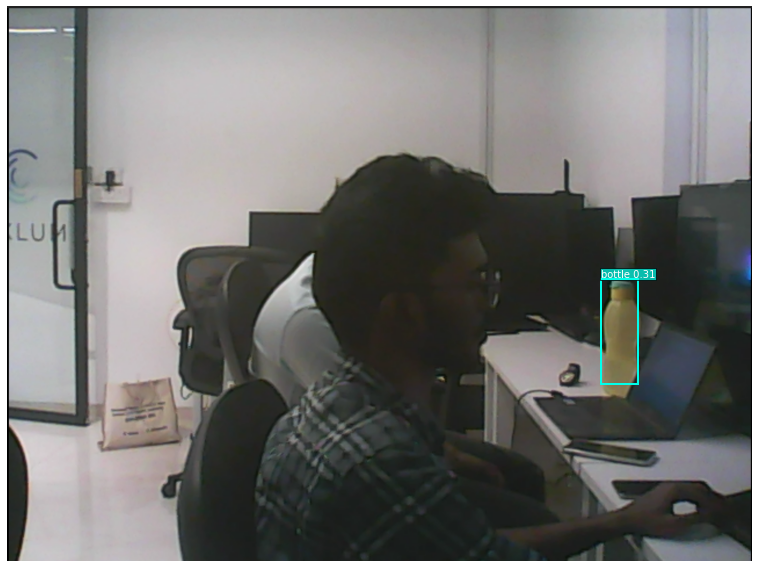

In [64]:
# ── Visualize detections ──────────────────────────────────────────────────

# Color palette for classes
COLORS = plt.cm.hsv(np.linspace(0, 1, NUM_CLASSES))

def draw_detections_letterbox(image_bgr, boxes, scores, classes,
                              input_size, lb_scale, lb_pad_w, lb_pad_h):
    """
    Draw bounding boxes on the original image.
    Undoes letterbox padding: box coords are in input_size space,
    so we subtract pad and divide by scale to get original pixel coords.
    """
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h_orig, w_orig = img_rgb.shape[:2]

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_rgb)

    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        # Undo letterbox: pixel coords in padded image → original image
        x1 = (x1 - lb_pad_w) / lb_scale
        y1 = (y1 - lb_pad_h) / lb_scale
        x2 = (x2 - lb_pad_w) / lb_scale
        y2 = (y2 - lb_pad_h) / lb_scale
        # Clamp
        x1 = max(0, min(x1, w_orig)); x2 = max(0, min(x2, w_orig))
        y1 = max(0, min(y1, h_orig)); y2 = max(0, min(y2, h_orig))

        c = int(classes[i])
        color = COLORS[c]

        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x1, y1 - 4,
                f'{COCO_CLASSES[c]} {scores[i]:.2f}',
                color='white', fontsize=10,
                bbox=dict(facecolor=color, alpha=0.7, pad=1))

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


draw_detections_letterbox(img_bgr, boxes, scores, classes,
                          INPUT_SIZE, scale, pad_w, pad_h)

## 11. PyTorch Reference (CPU Validation)

Optional: compare FPGA output with PyTorch CPU inference  
to verify numerical correctness of the fixed-point pipeline.

In [65]:
def pytorch_reference(img_path):
    """Run the same image through the PyTorch model on CPU
    with identical letterbox + ImageNet preprocessing."""
    img_bgr_ref = cv2.imread(img_path)
    if img_bgr_ref is None:
        pil_img = Image.open(img_path).convert('RGB')
        img_bgr_ref = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    h, w = img_bgr_ref.shape[:2]
    s = INPUT_SIZE / max(h, w)
    new_h, new_w = int(h * s), int(w * s)
    resized = cv2.resize(img_bgr_ref, (new_w, new_h))

    canvas = np.full((INPUT_SIZE, INPUT_SIZE, 3), 128, dtype=np.uint8)
    ph = (INPUT_SIZE - new_h) // 2
    pw = (INPUT_SIZE - new_w) // 2
    canvas[ph:ph+new_h, pw:pw+new_w] = resized

    rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    arr = rgb.astype(np.float32) / 255.0
    arr = (arr - IMAGENET_MEAN) / IMAGENET_STD
    tensor = torch.from_numpy(arr.transpose(2, 0, 1)).unsqueeze(0).float()

    with torch.no_grad():
        out = model(tensor)
    return out.squeeze(0).numpy()  # [125, 13, 13]


ref_output = pytorch_reference(IMAGE_PATH)

# Compare PL (FPGA fixed-point) vs PS (PyTorch float32)
diff = np.abs(raw_output - ref_output)
print(f'Max absolute difference : {diff.max():.6f}')
print(f'Mean absolute difference: {diff.mean():.6f}')
print(f'PyTorch output range    : [{ref_output.min():.3f}, {ref_output.max():.3f}]')
print(f'FPGA output range       : [{raw_output.min():.3f}, {raw_output.max():.3f}]')

Max absolute difference : 43.362335
Mean absolute difference: 0.183949
PyTorch output range    : [-171.362, 3.313]
FPGA output range       : [-128.000, 3.816]


## 12. Live Camera Feed Inference (PS / CPU only)

Continuously capture frames from a USB camera,
run Tiny-YOLO on each frame via **PyTorch on the ARM CPU (PS)**, and display detections in real time.

**Requirements:** OpenCV (`cv2`) — pre-installed on PYNQ images.  
Press **Stop** (interrupt kernel) to end the loop.

In [66]:
import cv2
from IPython.display import display, clear_output
import PIL

# ── Camera config ─────────────────────────────────────────────────────────
CAM_INDEX   = 0           # /dev/video0  (change for other cameras)
CAM_WIDTH   = 640
CAM_HEIGHT  = 480
SCORE_THRESH = 0.3
IOU_THRESH   = 0.4
MAX_FRAMES   = None       # set to an int to auto-stop, or None for infinite

COLORS_CV = (np.array(plt.cm.hsv(np.linspace(0, 1, NUM_CLASSES))[:, :3]) * 255
             ).astype(np.uint8).tolist()

# ── Open camera ───────────────────────────────────────────────────────────
cap = cv2.VideoCapture(CAM_INDEX)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, CAM_WIDTH)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, CAM_HEIGHT)

if not cap.isOpened():
    raise RuntimeError(f"Cannot open camera {CAM_INDEX}")
print(f"Camera opened: {int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))}x"
      f"{int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))}")

frame_count = 0
try:
    while True:
        ret, frame_bgr = cap.read()
        if not ret:
            print("Camera read failed, retrying...")
            continue

        # ── Letterbox preprocess (matches training pipeline) ──────────
        h_orig, w_orig = frame_bgr.shape[:2]
        lb_scale = INPUT_SIZE / max(h_orig, w_orig)
        new_h, new_w = int(h_orig * lb_scale), int(w_orig * lb_scale)
        resized = cv2.resize(frame_bgr, (new_w, new_h),
                             interpolation=cv2.INTER_LINEAR)
        canvas = np.full((INPUT_SIZE, INPUT_SIZE, 3), 128, dtype=np.uint8)
        pad_h = (INPUT_SIZE - new_h) // 2
        pad_w = (INPUT_SIZE - new_w) // 2
        canvas[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized

        # BGR → RGB, /255, ImageNet normalisation
        rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        img_float = rgb.astype(np.float32) / 255.0
        img_float = (img_float - IMAGENET_MEAN) / IMAGENET_STD
        img_chw   = img_float.transpose(2, 0, 1)          # [3, 416, 416]
        tensor    = torch.from_numpy(img_chw.astype(np.float32)).unsqueeze(0)

        # ── PS inference (PyTorch on ARM CPU) ─────────────────────────
        t_start = time.time()
        with torch.no_grad():
            raw_output = model(tensor).squeeze(0).numpy()  # [C, 13, 13]
        t_infer = time.time() - t_start

        # ── Post-process ──────────────────────────────────────────────
        boxes, scores, classes_det = decode_yolo(
            raw_output, ANCHORS, NUM_CLASSES,
            GRID_SIZE, GRID_SIZE, INPUT_SIZE)

        boxes, scores, classes_det = nms(
            boxes, scores, classes_det, SCORE_THRESH, IOU_THRESH)

        # ── Draw on original frame (undo letterbox) ───────────────────
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes[i]
            x1 = int((x1 - pad_w) / lb_scale)
            y1 = int((y1 - pad_h) / lb_scale)
            x2 = int((x2 - pad_w) / lb_scale)
            y2 = int((y2 - pad_h) / lb_scale)
            x1 = max(0, min(x1, w_orig)); x2 = max(0, min(x2, w_orig))
            y1 = max(0, min(y1, h_orig)); y2 = max(0, min(y2, h_orig))

            c = int(classes_det[i])
            color = COLORS_CV[c % len(COLORS_CV)]

            cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), color, 2)
            label = f"{COCO_CLASSES[c]} {scores[i]:.2f}"
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX,
                                          0.5, 1)
            cv2.rectangle(frame_rgb, (x1, y1 - th - 6),
                          (x1 + tw, y1), color, -1)
            cv2.putText(frame_rgb, label, (x1, y1 - 4),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255, 255, 255), 1, cv2.LINE_AA)

        fps = 1.0 / t_infer if t_infer > 0 else 0
        cv2.putText(frame_rgb,
                    f"PS FPS: {fps:.1f}  ({t_infer*1000:.0f} ms)",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                    (0, 255, 0), 2, cv2.LINE_AA)

        # ── Display in notebook ───────────────────────────────────────
        clear_output(wait=True)
        display(PIL.Image.fromarray(frame_rgb))

        frame_count += 1
        if MAX_FRAMES is not None and frame_count >= MAX_FRAMES:
            print(f"Stopped after {MAX_FRAMES} frames.")
            break

except KeyboardInterrupt:
    print(f"\nStopped by user after {frame_count} frames.")

finally:
    cap.release()
    print("Camera released.")


Stopped by user after 13 frames.
Camera released.


## 13. Cleanup

In [ ]:
# Free PYNQ buffers
buf_a.freebuffer()
buf_b.freebuffer()
weight_buf.freebuffer()
bn_buf.freebuffer()
print('Buffers freed.')

## 14. Live Camera + FPGA Inference (PL Accelerated)

Capture frames from USB camera, run Tiny-YOLO via **FPGA PL** (all 10 conv layers on hardware), draw detections, and display using fast JPEG encoding.  
Press **Stop** (interrupt kernel) to end.

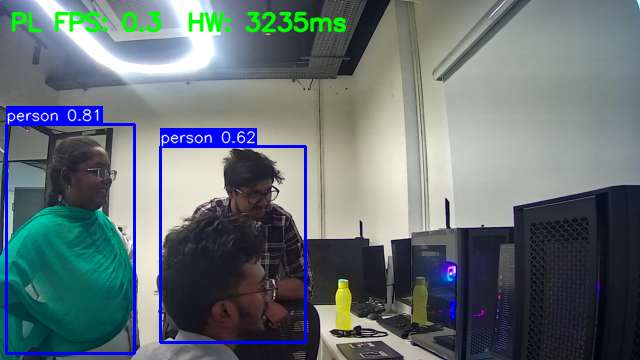


Stopped by user after 29 frames.
Camera released.


In [72]:
import cv2, time
from IPython.display import display, clear_output, Image as IPImage
import numpy as np

# ── Camera config ─────────────────────────────────────────────────────────
CAM_INDEX    = 0        # /dev/video0
CAM_WIDTH    = 640
CAM_HEIGHT   = 480
JPEG_QUALITY = 60
SCORE_THRESH = 0.3
IOU_THRESH   = 0.4
MAX_FRAMES   = None     # set to an int to auto-stop, or None for infinite

COLORS_CV = (np.array(plt.cm.hsv(np.linspace(0, 1, NUM_CLASSES))[:, :3]) * 255
             ).astype(np.uint8).tolist()

# ── Open camera ───────────────────────────────────────────────────────────
cap = cv2.VideoCapture(CAM_INDEX)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, CAM_WIDTH)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, CAM_HEIGHT)

if not cap.isOpened():
    raise RuntimeError(f"Cannot open camera {CAM_INDEX}")
print(f"Camera opened: {int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))}x"
      f"{int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))}")

frame_count = 0
t_prev = time.time()
try:
    while True:
        ret, frame_bgr = cap.read()
        if not ret:
            print("Camera read failed, retrying...")
            continue

        # ── Letterbox preprocess → fixed-point for PL ─────────────────
        img_fp_cam, lb_scale, pad_w, pad_h = preprocess_frame(frame_bgr)

        # ── PL inference (FPGA — all 10 conv layers on hardware) ──────
        t_start = time.time()
        raw_out = run_inference(img_fp_cam, verbose=False)  # [125, 13, 13]
        t_infer = time.time() - t_start

        # ── Post-process ──────────────────────────────────────────────
        boxes, scores, classes_det = decode_yolo(
            raw_out, ANCHORS, NUM_CLASSES,
            GRID_SIZE, GRID_SIZE, INPUT_SIZE)
        boxes, scores, classes_det = nms(
            boxes, scores, classes_det, SCORE_THRESH, IOU_THRESH)

        # ── Draw on original BGR frame (undo letterbox) ───────────────
        h_orig, w_orig = frame_bgr.shape[:2]
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes[i]
            x1 = int((x1 - pad_w) / lb_scale)
            y1 = int((y1 - pad_h) / lb_scale)
            x2 = int((x2 - pad_w) / lb_scale)
            y2 = int((y2 - pad_h) / lb_scale)
            x1 = max(0, min(x1, w_orig)); x2 = max(0, min(x2, w_orig))
            y1 = max(0, min(y1, h_orig)); y2 = max(0, min(y2, h_orig))

            c = int(classes_det[i])
            color = COLORS_CV[c % len(COLORS_CV)]

            cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), color, 2)
            label = f"{COCO_CLASSES[c]} {scores[i]:.2f}"
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX,
                                          0.5, 1)
            cv2.rectangle(frame_bgr, (x1, y1 - th - 6),
                          (x1 + tw, y1), color, -1)
            cv2.putText(frame_bgr, label, (x1, y1 - 4),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255, 255, 255), 1, cv2.LINE_AA)

        # ── FPS overlay ───────────────────────────────────────────────
        t_now = time.time()
        fps = 1.0 / max(t_now - t_prev, 1e-6)
        t_prev = t_now

        cv2.putText(frame_bgr,
                    f"PL FPS: {fps:.1f}  HW: {t_infer*1000:.0f}ms",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                    (0, 255, 0), 2, cv2.LINE_AA)

        # ── Encode JPEG & display ─────────────────────────────────────
        _, jpeg = cv2.imencode('.jpg', frame_bgr,
                               [cv2.IMWRITE_JPEG_QUALITY, JPEG_QUALITY])
        clear_output(wait=True)
        display(IPImage(data=jpeg.tobytes()))

        frame_count += 1
        if MAX_FRAMES is not None and frame_count >= MAX_FRAMES:
            print(f"Stopped after {MAX_FRAMES} frames.")
            break

except KeyboardInterrupt:
    print(f"\nStopped by user after {frame_count} frames.")

finally:
    cap.release()
    print("Camera released.")